## Importing Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from qiskit.circuit.library import XGate, ZGate, YGate, HGate, UGate, RXGate, RYGate
from qiskit.visualization import array_to_latex

## Loading Dataset

In [3]:
# initialize synthetic data with one feature and 2 clusters
X, y = make_blobs(n_features=1,n_samples=100, centers=2, random_state=2)

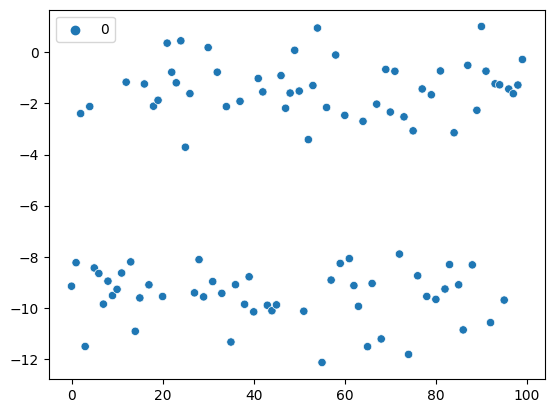

In [4]:
sns.scatterplot(X);

In [5]:
# Scaling the input data from -1 to 1 to enhance gate performance in encoding
minmax_scaler = MinMaxScaler(feature_range=(-1,1))
scaled_X = minmax_scaler.fit_transform(X)

## K-Means Clustering

In [6]:
kmeans = KMeans(n_clusters=2).fit(X)

In [7]:
labels_1 = np.array(kmeans.labels_)

In [8]:
silhouette_avg = silhouette_score(scaled_X, labels_1)

print(f"The average silhouette score is: {round(silhouette_avg,3)} %")

The average silhouette score is: 0.853 %


In [9]:
# use t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

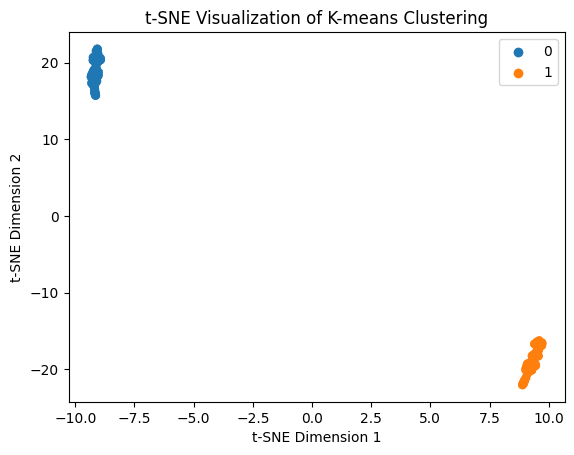

In [10]:
# Visualize the data points with their corresponding cluster assignments
t_sne_1 = X_tsne[:,0]
t_sne_2 = X_tsne[:,1]

sns.scatterplot(x=t_sne_1, y=t_sne_2,hue = labels_1, palette="tab10", edgecolor=None)
plt.title('t-SNE Visualization of K-means Clustering')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()

# Quantum Clustering

### Pipeline for implementing Quantum Clustering :

1. Initialize Quantum State: Define the init_state() function to initialize the ground state of a qubit.


2. Encode Data using RY Gates: Defining the encode_data(X) function to encode the input data using RY gates to transform them into quantum states.


3. K-Means Initialize Centroids: Defining the kMeansInitCentroids(encoded_data,K) function to initialize K centroids that are to be used in K-means on the dataset.


4. Compute Centroids: Defining the computeCentroids(encoded_data, idx,K) function to compute the new centroids by computing the means of the data points assigned to each centroid.


5. Calculate Fidelity: Defining the calculateFid(encoded_data_point, centroid) function to calculate the inner product between two quantum states,which represents the fidelity between them.


6. Find Closest Centroids: Defining the findClosestCentroids(encoded_data, centroids) function to compute the centroid memberships for every data sample by finding the closest centroid for each sample.


7. Quantum Clustering: Define the quantumClustering(X, n_clusters, max_iterations) function to perform the quantum clustering algorithm. This function encodes the data, initializes cluster centroids, assigns data points to clusters, and updates centroids iteratively.

In [11]:
# initialize quantum state
def init_state():
    """
        Initialize the ground state of qubit.
    
    Returns
    -------
        np.ndarray
        An array representing the initial quantum state.
    """
    return np.array([1, 0])

In [25]:
# encode data using RY gates
def encode_data(X):
    """
    Encode the input data using RY gates to transform them into quantum states.
    
    Parameters
    ----------
    X : array_like
        The input data to be encoded. It should be a one-dimensional array or list
        containing numerical values.

    Returns
    -------
        np.ndarray
        An array of quantum states representing the encoded data.
    """
    evolved_state = []
    state = init_state()
    
    for x in X:
        ry = RYGate(float(x)).to_matrix()  # 2x2 matrix
        evolved_state.append((np.dot(ry, state)).squeeze())
    
    evolved_state = np.array(evolved_state)
    return evolved_state


In [28]:
RYGate(-1).to_matrix()

array([[ 0.87758256+0.j,  0.47942554+0.j],
       [-0.47942554+0.j,  0.87758256+0.j]])

In [14]:
def computeCentroids(encoded_data, idx, K):
    """
    Returns the new centroids by computing the means of the data points
    assigned to each centroid.
    
    Parameters
    ----------
    encoded_data : array_like
        The dataset where each row is a single data point. That is, it 
        is a matrix of encoded data of size (m, n) where there are m datapoints each
        having n dimensions. 
    
    idx : array_like 
        A vector (size m) of centroid assignments (i.e. each entry in range [0 ... K-1])
        for each data sample.
    
    K : int
        Number of clusters
    
    Returns
    -------
    centroids : array_like
        A matrix of size (K, n) where each row is the mean of the data 
        points assigned to it.
    
    Instructions
    ------------
    Go over every centroid and compute mean of all points that
    belong to it. Concretely, the row vector centroids[i, :]
    should contain the mean of the data points assigned to
    cluster i.


    """

    m,n = encoded_data.shape
    centroids = np.zeros((K,n))
    
    
    for i in range(K):
        
        # caculating the centroids by computing the mean of points in each cluster
        centroids[i,:] = np.mean(encoded_data[idx==i],axis=0)

    return centroids

In [15]:
def kMeansInitCentroids(encoded_data, K):
    
    """
    This function initializes K centroids that are to be used in K-means on the dataset encoded_data.
    
    Parameters
    ----------
    encoded_data : array_like 
        The dataset of size (m x n).
    
    K : int
        The number of clusters.
    
    Returns
    -------
    centroids : array_like
        Centroids of the clusters. This is a matrix of size (K x n).
    
    Instructions
    ------------
    You should set centroids to randomly chosen encoded_datasamples from the dataset encoded_data.
    """
    
    m, n = encoded_data.shape
    centroids = np.zeros((K, n))
    idx = np.random.choice(m, K, replace=False)   # randomly sample K indices without replacement
    centroids = encoded_data[idx]
    
    return centroids

In [16]:
def calculateFid(encoded_data_point, centroid):
    """
    Calculate the inner product between two quantum states.
    Here the inputs are two ndarrays that represent the encoded data point and the centroid.
    
    Parameters
    ----------
    encoded_data : array_like
        The dataset of size (m, n) where each row is a single data sample. 
        That is, we have m data samples each of n dimensions.
        
    centroids : array_like
        The k-means centroids of size (K, n). K is the number
        of clusters, and n is the the data dimension.
        
    the output should be a real scalar represents the fidelity.
    """
    # The Fidelity between two quantum states is calculated using the following expression:  |⟨𝜓|𝜙⟩|^2=|⟨𝜙|𝜓⟩|^2
    
    inner_product = np.dot(centroid.conj().T, encoded_data_point)
    fid = np.abs(inner_product)**2
    
    return fid


In [17]:
def findClosestCentroids(encoded_data, centroids):
    """
    Computes the centroid memberships for every data sample.
    
    Parameters
    ----------
    encoded_data : array_like
        The dataset of size (m, n) where each row is a single data sample. 
        That is, we have m data samples each of n dimensions.
        
    centroids : array_like
        The k-means centroids of size (K, n). K is the number
        of clusters, and n is the the data dimension.
    
    Returns
    -------
    idx : array_like
        A vector of size (m, 1) which holds the centroids assignment for each
        encoded data sample (row) in the dataset encoded_data.
    
    Instructions
    ------------
    Go over every data sample, find its closest centroid, and store
    the index inside `idx` at the appropriate location.
    Concretely, idx[i] should contain the index of the centroid
    closest to data sample i. Hence, it should be a value in the 
    range 0..K-1
 
    """
    # number of centroids
    K = len(centroids)
    
    # initialize idencoded_data fidelities and distances arrays
    m = len(encoded_data)
    idx = np.zeros((m, 1), dtype=int)
    fidelities = np.zeros((m, K))

    # compute distances for each centroid
    for i , point in enumerate(encoded_data):
        for k in range(K):
            fidelities[i,k] = calculateFid(point, centroids[k])

    # find index of the closest centroid for each encoded datasample
    idx = np.argmax(fidelities , axis=1)
    
    return idx 


In [18]:
def quantumClustering(X,n_clusters,max_iterations=100):
    """
    This function gives the label of each data point in the dataset.
    
    Parameters
    ----------
    X : array_like
        The dataset of size (m x n).
    
    n_clusters : int
        The number of clusters.
        
    max_iterations : int
        The number of applied iterations.(default = 100)
    
    Returns
    -------
    labels : array_like
        Corresponding cluster of each data point. This is a matrix of size (m x 1).
    """
    m,n= X.shape
    
    # encode the data
    encoded_data = encode_data(X)
    
    # initialize cluster centroids randomly from the data
    centroids = kMeansInitCentroids(encoded_data, n_clusters)
    
    for _ in range(max_iterations):
        
        # assign data points to clusters
        labels = findClosestCentroids(encoded_data, centroids)
        
        # update cluster centroids
        centroids = computeCentroids(encoded_data,labels, n_clusters)
    
    return labels

In [23]:
labels_2 = quantumClustering(scaled_X , n_clusters=2,max_iterations=150)

C:\Users\hp\anaconda3\envs\mytfenv\lib\site-packages\ipykernel_launcher.py:43: ComplexWarning: Casting complex values to real discards the imaginary part


In [20]:
silhouette_avg = silhouette_score(X, labels_2)

print(f"The average silhouette score is: {round(silhouette_avg,3)}%")

The average silhouette score is: 0.853%


In [21]:
# use t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

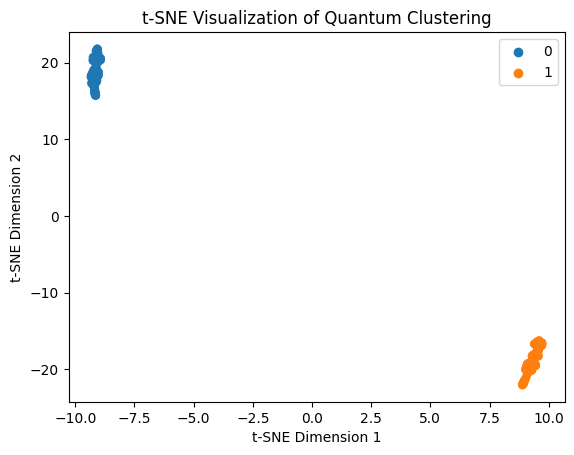

In [24]:
# Visualize the data points with their corresponding cluster assignments
t_sne_1 = X_tsne[:,0]
t_sne_2 = X_tsne[:,1]

sns.scatterplot(x=t_sne_1, y=t_sne_2,hue = labels_2, palette="tab10", edgecolor=None)
plt.title('t-SNE Visualization of Quantum Clustering')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()